In [185]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy

torch.manual_seed(42)


## Simple A/B test

P-Value: 0.1700


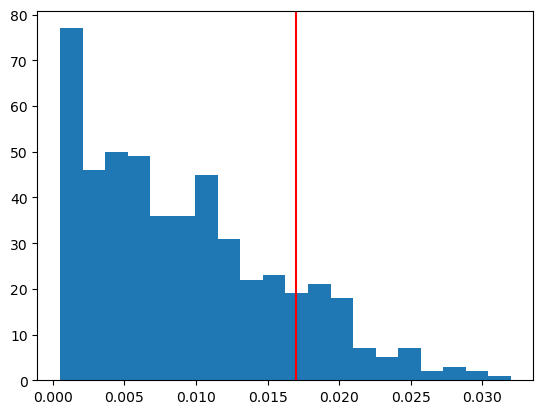

In [195]:
n_sim = 500

my_viewsA = 98
my_viewsB = 162
all_views = my_viewsA + my_viewsB

n_impsA = 1000
n_impsB = 2000
all_imps = n_impsA + n_impsB

obs_T = abs(my_viewsA/n_impsA - my_viewsB/n_impsB)

resampled_Ts = np.zeros(n_sim)

for cur_sim in range(n_sim):
    # Pool with 1s for views and 0s for non-views
    pool = np.array([1]*all_views + [0]*(all_imps - all_views))
    
    # Sample without replacement for impsA
    impsA = np.random.choice(pool, n_impsA, replace=False)
    viewsA = np.sum(impsA)
    viewsB = all_views - viewsA
    
    resampled_Ts[cur_sim] = abs(viewsA/n_impsA - viewsB/n_impsB)

p_value = sum([1 for t in resampled_Ts if t >= obs_T]) / n_sim

print(f"P-Value: {p_value:.4f}")


plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()



## Independence test with neural networks

In [186]:
class NNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(NNet, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(in_dim, 2*in_dim),
            nn.ReLU(),
            nn.Linear(2*in_dim, out_dim))

    def forward(self, x):
        return self.sequential(x)

In [187]:

p1 = 5
p2 = 3

signal_strength = 1.2

n_samples = 400

X = np.random.randn(n_samples, p1)

B = np.random.randn(p2, p1)
B = B / np.linalg.norm(B, ord='fro')

Y = signal_strength * np.sign(X) @ B.T + np.random.randn(n_samples, p2)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

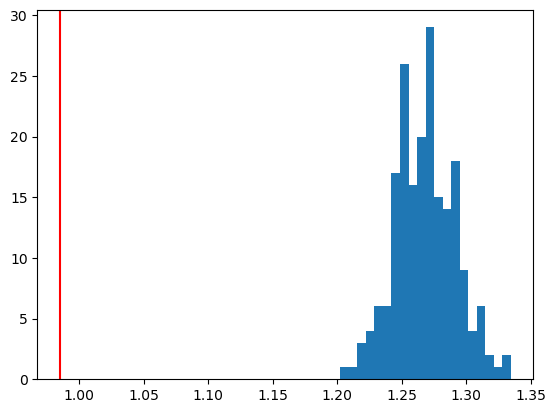

Original Test Statistic (Training Error): 0.9851
P-Value: 0.0000


In [188]:
def trainerr(x, y, epochs=200):
    net = NNet(p1, p2)

    optimizer = optim.Adam(net.parameters(), lr=0.2)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(x)
        
        loss = nn.MSELoss(reduction='mean')(outputs, y)
        loss.backward()
        optimizer.step()
    return loss.item()


obs_T = trainerr(X, Y)

# Perform permutation testing
n_permutations = 200
resampled_Ts = []

for _ in range(n_permutations):
    permuted_Y = Y[torch.randperm(n_samples)]

    resampled_T = trainerr(X, permuted_Y)
    
    resampled_Ts.append(resampled_T)

# Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

# plot distribution of permuted_test_statistics
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()


print(f"Original Test Statistic (Training Error): {obs_T:.4f}")
print(f"P-Value: {p_value:.4f}")



Mean test error: 3.8477
Null mean test error: 4.2937


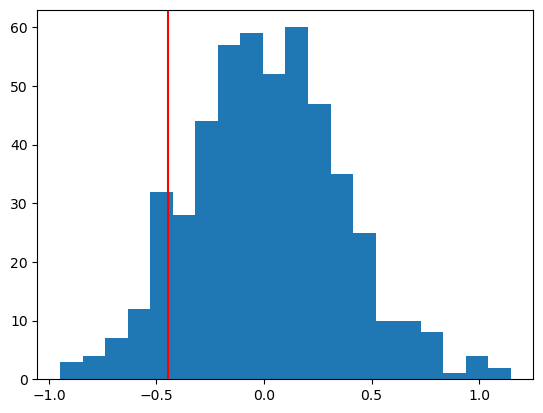

P-Value: 0.0980


In [189]:
## sample split
ntrain = int(n_samples * 0.5)
ntest = n_samples - ntrain

X_train = X[:ntrain]
X_test = X[ntrain:]

Y_train = Y[:ntrain]
Y_test = Y[ntrain:]

net = NNet(p1, p2)

epochs = 1000
optimizer = optim.SGD(net.parameters(), lr=0.2)
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(X_train)
        
    loss = nn.MSELoss(reduction='mean')(outputs, Y_train)
    loss.backward()
    optimizer.step()


testerrs = torch.sum((Y_test - net(X_test))**2, dim=1)
mean_testerr = torch.mean(testerrs)

null_testerrs = torch.sum((Y_test - torch.mean(Y_train, dim=0))**2, dim=1)
null_mean_testerr = torch.mean( null_testerrs )


print(f"Mean test error: {mean_testerr:.4f}")
print(f"Null mean test error: {null_mean_testerr:.4f}")


obs_T = mean_testerr - null_mean_testerr


combined = torch.cat([testerrs, null_testerrs])
n_permutations = 500
resampled_Ts = []
for _ in range(n_permutations):
    permuted_combined = combined[torch.randperm(ntest*2)]
    permuted_testerrs = permuted_combined[:ntest]
    permuted_null_testerrs = permuted_combined[ntest:]
    
    resampled_T = torch.mean(permuted_testerrs) - torch.mean(permuted_null_testerrs)
    resampled_Ts.append(resampled_T)

## Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

resampled_Ts = [t.detach().numpy() for t in resampled_Ts]
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T.detach().numpy(), color='red')
plt.show()

print(f"P-Value: {p_value:.4f}")
